In [1]:
import sys, os, glob, time, corner
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

sys.path.insert(0,'/home/isha/gw_detection_ias')
import utils as pipeline_utils
import time

In [2]:
sys.path.append('/home/isha/PopulationSelectionEffects/cogwheel_population_inference/cogwheel')
import cogwheel
from cogwheel import utils , data, sampling, gw_plotting, posterior
from cogwheel.factorized_qas import IntrinsicParametersPrior, MarginalizedRelativeBinningLikelihood
from cogwheel.population_inference.test_combined_priors import GaussianTestPopulationPrior
from cogwheel.population_inference.test_combined_priors import FixedTestPopulationPrior, FixedTestPrior
from cogwheel.gw_prior import extrinsic

/tmp/ipykernel_3727997/520647569.py:4: DeprecationWarning: 
The `factorized_qas` subpackage is deprecated.
The preferred way of marginalizing extrinsic parameters is now
`cogwheel.likelihood.MarginalizedExtrinsicLikelihoodQAS`
coupled to e.g. `gw_prior.IntrinsicAlignedSpinIASPrior`.
See  `tutorials/factorized_qas.ipynb` for an example.
  from cogwheel.factorized_qas import IntrinsicParametersPrior, MarginalizedRelativeBinningLikelihood


PriorError: PopulationModelPrior must override `get_init_dict` method.

In [ ]:
fname = 'test_prior'

In [ ]:
parentdir = '/home/isha/PopulationSelectionEffects/output/'

# grab the psds from any exisiting event - we will chnage the event name later
eventname = 'GW190521'

# [ Relative Binning ] #
post = posterior.Posterior.from_event(event=eventname, 
                                      mchirp_guess=90.0,
                                      approximant='IMRPhenomXPHM',
                                      prior_class=FixedTestPopulationPrior,
                                      ref_wf_finder_kwargs={'time_range':(-0.1,0.1)})


In [11]:
post.prior.range_dic

{'m1': array([-10.,  10.]), 'm2': array([-10.,  10.])}

Searching incoherent solution for GW190521
Set intrinsic parameters, lnL = 112.22603774880282
Set time, lnL(L) = 69.50205688113566
Set sky location, lnL = 109.45603448044056
Set phase and distance, lnL = 109.45603448044056
Set mchirp_range = (46.448282781049414, 174.39875710336486)
PE rundir : /home/isha/PopulationSelectionEffects/output/TestPrior/test_prior/run_9
*
 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points = 1024
 dimensionality =   10
 *****************************************************
 ln(ev)=  -7.1134438762581294      +/-   8.9431702491955423E-002
 Total Likelihood Evaluations:        25336
 Sampling finished. Exiting MultiNest
Done!
time taken : 99.166


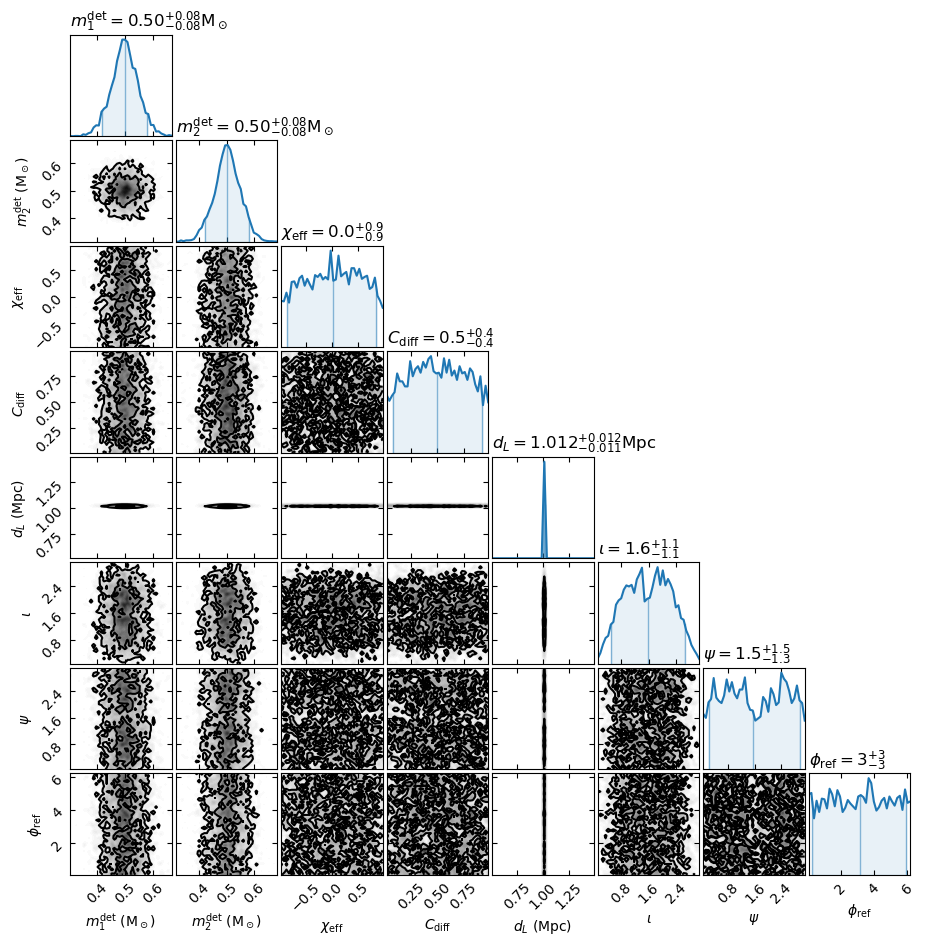

In [19]:
t1 = time.time()

# [ Directory Setup ] #
parentdir = '/home/isha/PopulationSelectionEffects/output/'

# grab the psds from any exisiting event - we will chnage the event name later
eventname = 'GW190521'

# [ Relative Binning ] #
post = posterior.Posterior.from_event(event=eventname, 
                                      mchirp_guess=90.0,
                                      approximant='IMRPhenomXPHM',
                                      prior_class=TestPrior,
                                      ref_wf_finder_kwargs={'time_range':(-0.1,0.1)})

# instantiate the sampler
pym = sampling.PyMultiNest(post, sample_prior=True)

# change the event name so you do not save the samples somewhere else 
# or overwrite posteriors samples for the event
post.likelihood.event_data.eventname = fname

# set the sampler 
pym.run_kwargs = {'n_iter_before_update': 1000,'n_live_points': 1024,'evidence_tolerance': 0.15}

# get the run directory and print it for future references
rundir = pym.get_rundir(parentdir)
print('PE rundir : %s\n*'%rundir)

# perform the pe now
pym.run(rundir)

# read the samples
samples = pd.read_feather('%s/samples.feather'%rundir)
print('Done!')
# count the number of samples

# calculate the time taken
t2 = time.time()
print('time taken : %.3f'%(t2-t1))

# plot the samples
gw_plotting.CornerPlot(samples[['m1', 'm2', 'chieff', 'cumchidiff', 'd_luminosity', 'iota', 'psi', 'phi_ref']],
                       bins=40
                      ).plot()
#plt.savefig("population_samples.pdf", dpi=300)

In [9]:
pym.posterior.prior.sampled_params

['cosiota',
 'costhetanet',
 'phinet_hat',
 't_refdet',
 'psi',
 'phi_ref_hat',
 'm1',
 'm2',
 'chieff',
 'cumchidiff']

In [8]:
np.log(400)

5.991464547107982

In [16]:
log_vol = np.log(2)+np.log(2)+np.log(2*np.pi)+np.log(0.14)+np.log(np.pi)+np.log(2)+np.log(400)+np.log(2*np.pi)

In [17]:
log_vol

10.925277251083077

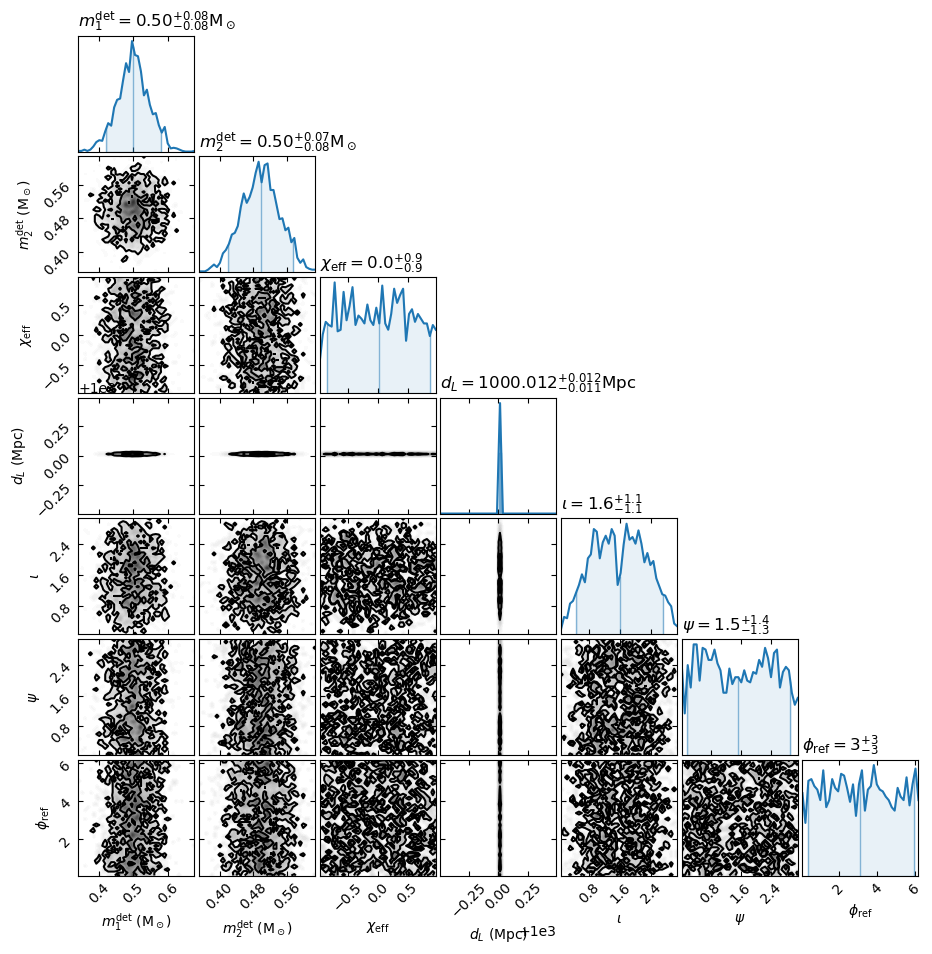

In [5]:
gw_plotting.CornerPlot(samples[['m1', 'm2', 'chieff', 'd_luminosity', 'iota', 'psi', 'phi_ref']],
                       bins=40
                      ).plot()

In [5]:
%debug

> /home/isha/miniconda3/envs/cogwheel_population/lib/python3.9/site-packages/numpy/lib/npyio.py(734)floatconv()
    732         if '0x' in x:
    733             return float.fromhex(x)
--> 734         return float(x)
    735 
    736     typ = dtype.type

ipdb> up
> /home/isha/miniconda3/envs/cogwheel_population/lib/python3.9/site-packages/numpy/lib/npyio.py(997)<listcomp>()
    995 
    996             # Convert each value according to its column and store
--> 997             items = [conv(val) for (conv, val) in zip(converters, vals)]
    998 
    999             # Then pack it according to the dtype's nesting

ipdb> up
> /home/isha/miniconda3/envs/cogwheel_population/lib/python3.9/site-packages/numpy/lib/npyio.py(997)read_data()
    995 
    996             # Convert each value according to its column and store
--> 997             items = [conv(val) for (conv, val) in zip(converters, vals)]
    998 
    999             # Then pack it according to the dtype's nesting

ipdb> up
> /ho

In [10]:
pym.posterior.

<bound method RelativeBinningLikelihood.lnlike of RelativeBinningLikelihood(test_prior)>

In [7]:
likelihood_params = set(['d_luminosity', 'dec', 'f_ref', 'iota', 'l1', 'l2', 'm1', 'm2', 'phi_ref', 'psi', 'ra', 's1x_n', 's1y_n', 's1z', 's2x_n', 's2y_n', 's2z', 't_geocenter'])
standard_params = set(['iota', 'ra', 'dec', 't_geocenter', 'psi', 'phi_ref', 'm1', 'm2', 's1z', 's2z', 's1x_n', 's1y_n', 's2x_n', 's2y_n', 'l1', 'l2', 'f_ref'])

In [9]:
len(likelihood_params.intersection(standard_params))

17

In [11]:
likelihood_params == standard_params

False

In [13]:
len(likelihood_params)

18